This notebook is the second part of the mental health analysis of the Caribbean project which seeks to assess the prevalence of mental health disorders regionally. The inspiration behind the report came from my report on youth mental health in Jamaica which assessed the resources available for care. The report found that the resources available are distressfully inadequate to service the need.  The full report can be accessed here: https://www.capricaribbean.org/documents/mind-gap-inadequacy-mental-health-services-children-revised-october-2021.
The report lacked a comprehensive and current analysis of the prevalence of disorders regionally which this data science project aimed to address.

The first part of the project assessed disorder prevalence across the region using a Dataset taken from Kaggle. It showed that depression and anxiety were the most prevalent disorders in the region and there were significant relationships between both disorders and alcohol consumption and drug use. The full analysis can be accessed here: 

The analysis below seeks to gain the opinions and sentiments of Caribbean Twitter users on anxiety, depression and mental health. 

In [1]:
import snscrape.modules.twitter as sntwitter #I first added this to the terminal as a new command
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce #To carry out merging of multiple data frames
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification #For Sentiment Analysis
from scipy.special import softmax #For Sentiment Analysis
import torch 
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')


# Checking Mental Health Terms Across Four Countries

In [2]:
#Checking tweets on depression

maxtweets = 300

tweets1_list = []

# locations = ['Montego Bay', 'Port of Spain']

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('depressed near:"Port of Spain" within:50km').get_items()):
    if i>maxtweets:
        break
    
    tweets1_list.append([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.likeCount, tweet.retweetCount, tweet.quotedTweet])

#I was unable to put all CARICOM countries in a list & then use a for loop to run the Twitter location search through each one
#As a work around, I ran searches on depression & anxiety in 4 islands (one island per search term) and then mental health search across all
#No need for a specific time range as the sample I ran for Barbados gave tweets dating back to 2017.  
#I decided to remove searches for anxious because the term can be used for frivolous things that are not mental health related

In [3]:
#Checking tweets for anxiety 
maxtweets = 300

tweets2_list = []

# locations = ['Jamaica', 'Trinidad & Tobago']

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('anxiety near:"Bridgetown" within:50km').get_items()):
    if i>maxtweets:
        break
    tweets2_list.append([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.likeCount, tweet.retweetCount, tweet.quotedTweet])

In [4]:
#Checking tweets on depression
maxtweets = 300

tweets3_list = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('depressed near:"Montego Bay" within:50km').get_items()):
    if i>maxtweets:
        break
    tweets3_list.append([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.likeCount, tweet.retweetCount, tweet.quotedTweet])

In [5]:
#Checking tweets on depression/anxiety
maxtweets = 300

tweets4_list = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('stressed near:"Guyana" within:10km').get_items()):
    if i>maxtweets:
        break
    tweets4_list.append([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.likeCount, tweet.retweetCount, tweet.quotedTweet])

# Checking Tweets About Mental Health in Each of the Countries

In [6]:
maxtweets = 300

tweets5_list = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('mental health near:"Montego Bay" within:50km').get_items()):
    if i>maxtweets:
        break
    tweets5_list.append([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.likeCount, tweet.retweetCount, tweet.quotedTweet])

In [7]:
maxtweets = 300

tweets6_list = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('mental health near:"Port of Spain" within:50km').get_items()):
    if i>maxtweets:
        break
    tweets6_list.append([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.likeCount, tweet.retweetCount, tweet.quotedTweet])

In [8]:
maxtweets = 300

tweets7_list = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('mental health near:"Bridgetown" within:50km').get_items()):
    if i>maxtweets:
        break
    tweets7_list.append([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.likeCount, tweet.retweetCount, tweet.quotedTweet])

In [12]:
maxtweets = 300

tweets8_list = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('mental health near:"Guyana" within:50km').get_items()):
    if i>maxtweets:
        break
    tweets8_list.append([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.likeCount, tweet.retweetCount, tweet.quotedTweet])

# Creating Data Frames & Merging These into One

In [13]:
#Creating Dataframe
tweets1_df = pd.DataFrame(tweets1_list, columns=['ID', 'Date', 'Content', 'Reply Count', 'Likes', 'Retweets', 'Quotes'])

In [14]:
#Creating Dataframe
tweets2_df = pd.DataFrame(tweets2_list, columns=['ID', 'Date', 'Content', 'Reply Count', 'Likes', 'Retweets', 'Quotes'])

In [15]:
#Creating Dataframe
tweets3_df = pd.DataFrame(tweets3_list, columns=['ID', 'Date','Content', 'Reply Count', 'Likes', 'Retweets', 'Quotes'])

In [16]:
#Creating Dataframe
tweets4_df = pd.DataFrame(tweets4_list, columns=['ID', 'Date', 'Content', 'Reply Count', 'Likes', 'Retweets', 'Quotes'])

In [17]:
#Creating Dataframe
tweets5_df = pd.DataFrame(tweets5_list, columns=['ID', 'Date', 'Content', 'Reply Count', 'Likes', 'Retweets', 'Quotes'])

In [18]:
#Creating Dataframe
tweets6_df = pd.DataFrame(tweets6_list, columns=['ID', 'Date','Content', 'Reply Count', 'Likes', 'Retweets', 'Quotes'])

In [19]:
tweets7_df = pd.DataFrame(tweets7_list, columns=['ID', 'Date', 'Content', 'Reply Count', 'Likes', 'Retweets', 'Quotes'])

In [20]:
tweets8_df = pd.DataFrame(tweets8_list, columns=['ID', 'Date', 'Content', 'Reply Count', 'Likes', 'Retweets', 'Quotes'])

There was a problem with merging the datasets using the following code as I was losing over 80% of info throughout the dataframe: 

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Content'],
                                            how='outer'), data_frames


The individual dataframes did not have that high % of null values so the merge was erasing information. I searched around and used the code below to successfully merge the datasets. The code below also automatically removed duplicate columns. 

In [21]:
# Merging multiple data frames into one 
data_frames = [tweets1_df, tweets2_df, tweets3_df, tweets4_df, tweets5_df, tweets6_df, tweets7_df, tweets8_df]

tweets_df = pd.concat(data_frames, axis=0, ignore_index=True)

tweets_df.head()

,ID,Date,Content,Reply Count,Likes,Retweets,Quotes
0,1591879584877891588,2022-11-13 19:44:03+00:00,@PaulMitchell_AB @Dr_Voll So if you call the s...,0,0,0,None
1,1591484387388194816,2022-11-12 17:33:40+00:00,"This is, um, horrific.\n\nStarting March 17th,...",0,1,0,https://twitter.com/globeandmail/status/159117...
2,1591278282242109440,2022-11-12 03:54:41+00:00,@HomerTrajan I don't think I got very much out...,1,1,0,None
3,1591123844601114624,2022-11-11 17:41:00+00:00,Every time I have a conversation with my colle...,0,7,2,None
4,1591080966227128320,2022-11-11 14:50:37+00:00,i get depressed for like 6-8 hours and then i’...,1,1,1,None


# Data Cleaning 

In [22]:
#Getting number of rows & columns. Note that the results are less than the no. of tweets I specfied above as some countries did not yield the no. requested. 

tweets_df.shape

(1600, 7)

In [23]:
#Checking for any Null Values

for col in tweets_df.columns:
    pct_missing = np.mean(tweets_df[col].isnull())
    print(' {} - {}%'.format(col, round(pct_missing*100)))

 ID - 0%
 Date - 0%
 Content - 0%
 Reply Count - 0%
 Likes - 0%
 Retweets - 0%
 Quotes - 90%


In [24]:
#Running a quick statistical overview of the dataframe
tweets_df.describe()

,ID,Reply Count,Likes,Retweets
count,1.600000e+03,1600.000000,1600.000000,1600.000000
mean,1.317547e+18,0.488125,6.201250,1.226875
std,2.617210e+17,2.416818,29.946765,6.368536
min,1.473220e+17,0.000000,0.000000,0.000000
25%,1.262616e+18,0.000000,0.000000,0.000000
50%,1.367165e+18,0.000000,1.000000,0.000000
75%,1.477474e+18,1.000000,3.000000,0.000000
max,1.591922e+18,70.000000,591.000000,99.000000


The standard deviation across key numeric values is larger than the mean which signifies that the data is spread out across the dataframe. This is particularly the case for the likes and retweets which are between 5 and 7 times larger than the mean. The average likes and retweets are low which means there is no way to conclusively determine whether others support or feel the same about the tweet in question. 

In [25]:
#Fetching the tweets with the most replies

tweets_df.sort_values(by='Reply Count', ascending=False)[:10]

,ID,Date,Content,Reply Count,Likes,Retweets,Quotes
129,1349801270790524929,2021-01-14 19:31:15+00:00,So many holes in this Sonny story... I’m going...,70,303,23,None
1274,1473690361356824587,2021-12-22 16:22:16+00:00,I’m doing a #MentalHealth experiment with my t...,48,545,23,None
511,1308456355360108546,2020-09-22 17:21:19+00:00,Do people who have anxiety actually enjoy thei...,19,75,7,None
1264,1481600732071661571,2022-01-13 12:15:15+00:00,Okay friends: this talk on #MentalHealth at wo...,17,48,6,None
1454,1285921755236900865,2020-07-22 12:56:52+00:00,Jim Morrison\nChris Cornell\nWayne Static\nChe...,15,177,41,None
1269,1478008106781138944,2022-01-03 14:19:27+00:00,"Because I have both focus + commitment issues,...",13,124,3,None
1272,1476538053749575685,2021-12-30 12:57:59+00:00,I’m proactively scheduling a new fun thing eve...,11,105,3,None
1221,1579148951152103425,2022-10-09 16:37:03+00:00,@andie1105 Wait… you are a supporter of a ment...,9,65,2,None
942,1574534233712103424,2022-09-26 22:59:49+00:00,Rows wrong for saying people should leave at a...,9,591,95,None
171,1303900684333580288,2020-09-10 03:38:43+00:00,Lol think I’m gonna get depressed PLUS fuck to...,7,52,8,https://twitter.com/__ur_highness/status/13035...


In [26]:
#Most Likes

tweets_df.sort_values(by='Likes', ascending=False)[:10]

,ID,Date,Content,Reply Count,Likes,Retweets,Quotes
942,1574534233712103424,2022-09-26 22:59:49+00:00,Rows wrong for saying people should leave at a...,9,591,95,None
1274,1473690361356824587,2021-12-22 16:22:16+00:00,I’m doing a #MentalHealth experiment with my t...,48,545,23,None
931,1579487550179512324,2022-10-10 15:02:32+00:00,Today is world Mental Health Day and they didn...,5,303,43,None
129,1349801270790524929,2021-01-14 19:31:15+00:00,So many holes in this Sonny story... I’m going...,70,303,23,None
1239,1550512881061531650,2022-07-22 16:07:32+00:00,A lot of wanna on hear talking bout mental hea...,0,300,75,None
1193,1394630184251412482,2021-05-18 12:25:21+00:00,Wishing that straight people gay children as s...,0,274,44,None
1056,1480011148925800458,2022-01-09 02:58:49+00:00,We making mental health a big priority this ye...,0,252,55,None
1347,1368367735521050625,2021-03-07 01:07:45+00:00,Can we acknowledge the positive effect that th...,0,242,55,None
1454,1285921755236900865,2020-07-22 12:56:52+00:00,Jim Morrison\nChris Cornell\nWayne Static\nChe...,15,177,41,None
729,1308188845448536064,2020-09-21 23:38:20+00:00,"Hey Siri , play #wizkid No Stress \n@wizkidayo...",1,167,30,None


In [27]:
#Most Retweets

tweets_df.sort_values(by='Retweets', ascending=False)[:10]

,ID,Date,Content,Reply Count,Likes,Retweets,Quotes
1492,1208504290446315521,2019-12-21 21:47:30+00:00,Never underestimate how important your mental ...,1,109,99,None
942,1574534233712103424,2022-09-26 22:59:49+00:00,Rows wrong for saying people should leave at a...,9,591,95,None
1239,1550512881061531650,2022-07-22 16:07:32+00:00,A lot of wanna on hear talking bout mental hea...,0,300,75,None
1501,1189545929684213763,2019-10-30 14:13:44+00:00,Iz work in customer service. And I KNOW that w...,2,115,71,None
19,1589081222302826496,2022-11-06 02:24:21+00:00,CHARMING SPRINGS - she is 20 y.o. \nMother of...,3,52,69,None
1056,1480011148925800458,2022-01-09 02:58:49+00:00,We making mental health a big priority this ye...,0,252,55,None
1347,1368367735521050625,2021-03-07 01:07:45+00:00,Can we acknowledge the positive effect that th...,0,242,55,None
1336,1382647032272281600,2021-04-15 10:48:35+00:00,The “stop complaining and be grateful because ...,2,129,52,None
1388,1344215683165544454,2020-12-30 09:36:07+00:00,Dont advocate mental health importance and mak...,1,144,47,None
1490,1219324994200707074,2020-01-20 18:25:07+00:00,Wunna does bully people on hay then champion f...,1,75,45,None


# Sentiment Analysis 

In [28]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tochukwuonyido/nltk_data...
[nltk_data] Downloading package words to
[nltk_data]     /Users/tochukwuonyido/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [29]:
#How to do a quick test on the tweet with the most retweets to test if the sentiment is assigned
# sentence = tweets_df['Content'][1494]
# sid.polarity_scores(sentence)['compound']



In [30]:
#Cleaning tweets, removing non-word elements & creating a new column with clean tweets
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet)
         if w.lower() in words or not w.isalpha())
    return tweet
    

tweets_df['tweet_clean'] = tweets_df['Content'].apply(cleaner)

tweets_df.head() 

,ID,Date,Content,Reply Count,Likes,Retweets,Quotes,tweet_clean
0,1591879584877891588,2022-11-13 19:44:03+00:00,@PaulMitchell_AB @Dr_Voll So if you call the s...,0,0,0,None,"So if you call the suicide , it ' s actually t..."
1,1591484387388194816,2022-11-12 17:33:40+00:00,"This is, um, horrific.\n\nStarting March 17th,...",0,1,0,https://twitter.com/globeandmail/status/159117...,"This is , um , horrific . Starting March 17th ..."
2,1591278282242109440,2022-11-12 03:54:41+00:00,@HomerTrajan I don't think I got very much out...,1,1,0,None,I don ' t think I got very much out of college...
3,1591123844601114624,2022-11-11 17:41:00+00:00,Every time I have a conversation with my colle...,0,7,2,None,Every time I have a conversation with my about...
4,1591080966227128320,2022-11-11 14:50:37+00:00,i get depressed for like 6-8 hours and then i’...,1,1,1,None,i get depressed for like 6 - 8 and then i ’ m ...


In [31]:
#Looping through tweets and assigning sentiments to each one
list1 = []
for i in tweets_df['tweet_clean']:
    list1.append((sid.polarity_scores(str(i)))['compound'])

In [32]:
#Including a written description for each tweet for easier interpretation

tweets_df['sentiment'] = pd.Series(list1)

def sentiment_category(sentiment):
    label = ''
    if(sentiment>0):
        label = 'positive'
    elif(sentiment == 0):
        label = 'neutral'
    else:
        label = 'negative'
    return(label)

tweets_df['sentiment_category'] = tweets_df['sentiment'].apply(sentiment_category)

In [33]:
tweets_df.head()

,ID,Date,Content,Reply Count,Likes,Retweets,Quotes,tweet_clean,sentiment,sentiment_category
0,1591879584877891588,2022-11-13 19:44:03+00:00,@PaulMitchell_AB @Dr_Voll So if you call the s...,0,0,0,None,"So if you call the suicide , it ' s actually t...",-0.8555,negative
1,1591484387388194816,2022-11-12 17:33:40+00:00,"This is, um, horrific.\n\nStarting March 17th,...",0,1,0,https://twitter.com/globeandmail/status/159117...,"This is , um , horrific . Starting March 17th ...",-0.9565,negative
2,1591278282242109440,2022-11-12 03:54:41+00:00,@HomerTrajan I don't think I got very much out...,1,1,0,None,I don ' t think I got very much out of college...,-0.5106,negative
3,1591123844601114624,2022-11-11 17:41:00+00:00,Every time I have a conversation with my colle...,0,7,2,None,Every time I have a conversation with my about...,-0.5106,negative
4,1591080966227128320,2022-11-11 14:50:37+00:00,i get depressed for like 6-8 hours and then i’...,1,1,1,None,i get depressed for like 6 - 8 and then i ’ m ...,0.4019,positive


In [34]:
#Checking the count of sentiments

tweets_df['sentiment_category'].value_counts()

negative    793
positive    612
neutral     195
Name: sentiment_category, dtype: int64

In [37]:
#Creating wordcloud to see positive words

from wordcloud import WordCloud

In [38]:
#Checking changes in sentiment over time
neg = tweets_df[tweets_df['sentiment_category']=='negative']
neg = neg.groupby(['Date'],as_index=False).count()

pos = tweets_df[tweets_df['sentiment_category']=='positive']
pos = pos.groupby(['Date'],as_index=False).count()

pos = pos[['Date', 'ID']]
neg = neg[['Date', 'ID']]

In [114]:
import orca

In [115]:
import plotly.graph_objs as go
fig = go.Figure()
for col in pos.columns:
    fig.add_trace(go.Scatter(x=pos['Date'], y=pos['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='green'
                             )
                 )

for col in neg.columns:
    fig.add_trace(go.Scatter(x=neg['Date'], y=neg['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='red'
                             )
                 )

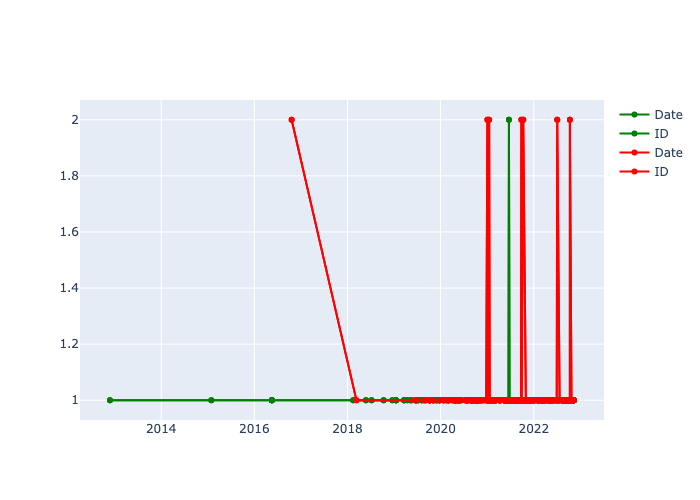

In [122]:
fig.show('png')
#fig.write_image('fig.png', engine='orca')

Firstly, there are more instances of spiking for negative sentiments than positive sentiments specifically from July to December 2016, January to February 2021 and October 2021 to November 2021. There are also spikes in July and October 2022. It is interesting to note that there is only one positive spike in the analysis period. The spike took place in October 2020 which was at the heights of the second wave of Covid-19 pandemic.  

I will assess the spikes in negative sentiments to determine any key words that could point to significant events that could have caused the spikes. In addition, I will also focus specifically on tweets that contain the term 'mental health' from the original dataset to see if there are any hidden findings. 

In [123]:
spike1_df = tweets_df[(tweets_df['Date']>='2016-07-01') & (tweets_df['Date']<='2016-12-31')]

neg = spike1_df[spike1_df['sentiment_category']=='negative']
neg = neg.groupby(['Date'],as_index=False).count()

pos = spike1_df[spike1_df['sentiment_category']=='positive']
pos = pos.groupby(['Date'],as_index=False).count()

pos = pos[['Date','ID']]
neg = neg[['Date','ID']]

In [124]:
#Generating chart for visualization

fig = go.Figure()
for col in pos.columns:
    fig.add_trace(go.Scatter(x=pos['Date'], y=pos['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='green'
                             )
                 )

for col in neg.columns:
    fig.add_trace(go.Scatter(x=neg['Date'], y=neg['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='red'
                             )
                 )


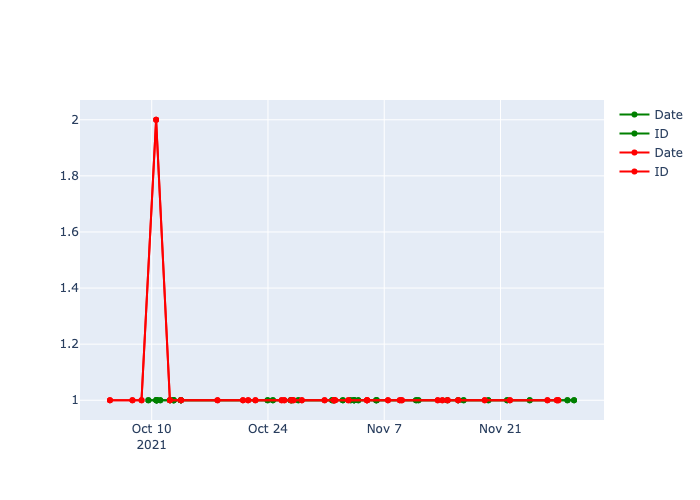

In [143]:
fig.show('png')
  


There is a steady increase over the months of August, September with the peak on October 19, 2016. There is then a steady decline from that date until the end of December of that year. There aren't any notable events that could be identified which could have caused this spike. Let's look at the Wordcloud to see if we could get an indication of what was taking pace at that time. 

(-0.5, 399.5, 199.5, -0.5)

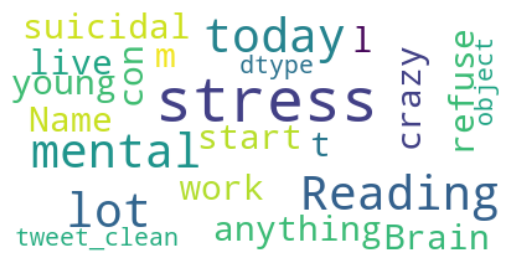

In [126]:
#Checking wordcloud
spike1_df = tweets_df[(tweets_df['Date']>='2016-07-01') & (tweets_df['Date']<='2016-12-31')]
negative = spike1_df[spike1_df['sentiment_category']=='negative']
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(negative['tweet_clean']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [127]:
plt.show()

The Wordcloud indicates that there were some strong negative feelings which were evident during this time period. Prominent words such as 'suicidal', 'brain', 'stress' & 'mental' can be seen in this small cloud. There are also other words such as 'young' & 'refuse'. Moving now to assess the other spikes. 

In [128]:
spike2_df = tweets_df[(tweets_df['Date']>='2021-01-01') & (tweets_df['Date']<='2021-02-28')]

neg = spike2_df[spike2_df['sentiment_category']=='negative']
neg = neg.groupby(['Date'],as_index=False).count()

pos = spike2_df[spike2_df['sentiment_category']=='positive']
pos = pos.groupby(['Date'],as_index=False).count()

pos = pos[['Date','ID']]
neg = neg[['Date','ID']]

In [129]:
#Generating chart for visualization

fig = go.Figure()
for col in pos.columns:
    fig.add_trace(go.Scatter(x=pos['Date'], y=pos['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='green'
                             )
                 )

for col in neg.columns:
    fig.add_trace(go.Scatter(x=neg['Date'], y=neg['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='red'
                             )
                 )


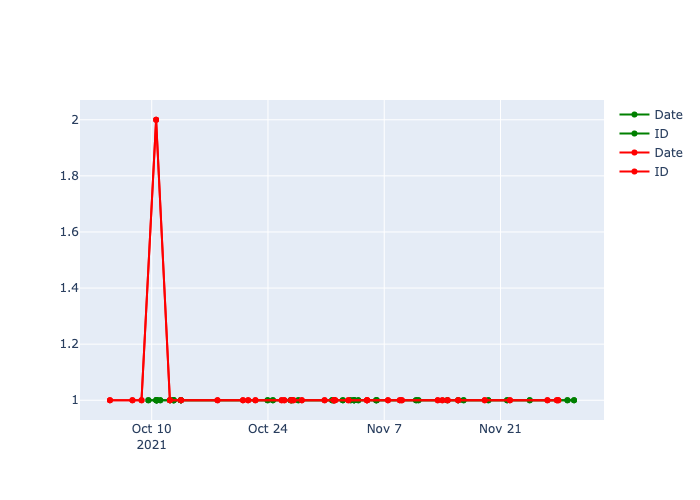

In [144]:
fig.show('png')

There is a spike on January 02, 2021 which declines instantly followed by another spike on January 14, 2021 where the spike is maintained until the 18th of that month. There are no further spikes after that date. 

(-0.5, 399.5, 199.5, -0.5)

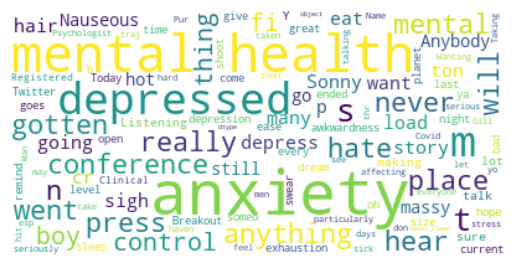

In [145]:
#Assessing the Wordcloud

spike2_df = tweets_df[(tweets_df['Date']>='2021-01-01') & (tweets_df['Date']<='2021-02-28')]
negative = spike2_df[spike2_df['sentiment_category']=='negative']
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(negative['tweet_clean']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [146]:
plt.show()

There are substantially more words generated for this time period. Words such as 'mental health', 'anxiety',  'hate and 'control' are more prominent in the cloud. The word 'Conference' is also prominent which could indicate that there was a summit of sorts on mental health during this time period. At the time we were entering into Year 2 of the pandemic and so the conference could have been an attempt to raise awareness on the importance of mental health care.

In [147]:
#Checking the final spike 

spike3_df = tweets_df[(tweets_df['Date']>='2021-10-01') & (tweets_df['Date']<='2021-11-30')]

neg = spike3_df[spike3_df['sentiment_category']=='negative']
neg = neg.groupby(['Date'],as_index=False).count()

pos = spike3_df[spike3_df['sentiment_category']=='positive']
pos = pos.groupby(['Date'],as_index=False).count()

pos = pos[['Date','ID']]
neg = neg[['Date','ID']]

In [148]:
fig = go.Figure()
for col in pos.columns:
    fig.add_trace(go.Scatter(x=pos['Date'], y=pos['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='green'
                             )
                 )

for col in neg.columns:
    fig.add_trace(go.Scatter(x=neg['Date'], y=neg['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='red'
                             )
                 )

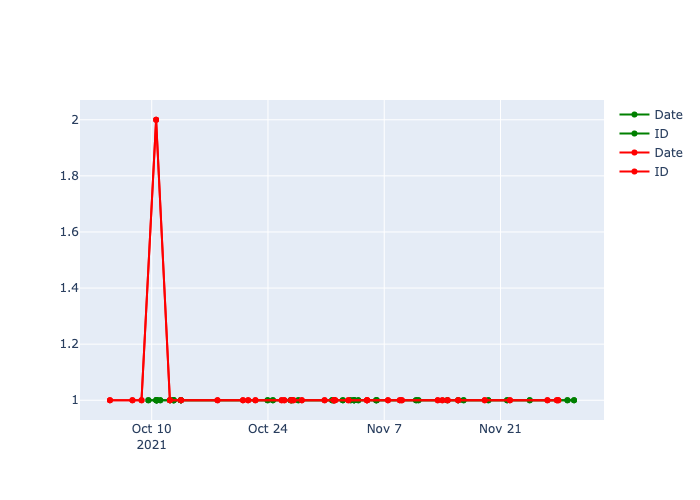

In [149]:
fig.show('png')

The spike occurred on October 08th and was back to base levels by October 10th. 

(-0.5, 399.5, 199.5, -0.5)

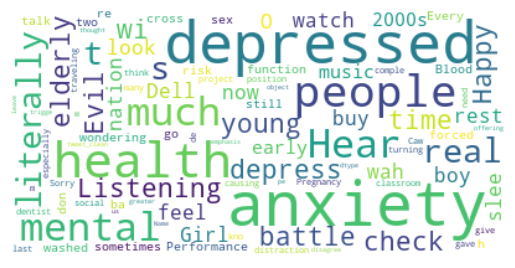

In [150]:
#Assessing the Wordcloud

spike3_df = tweets_df[(tweets_df['Date']>='2021-10-01') & (tweets_df['Date']<='2021-11-30')]
negative = spike3_df[spike3_df['sentiment_category']=='negative']
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(negative['tweet_clean']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [151]:
plt.show()

There are some similar words shown in this cloud as with the previous cloud. There are new additions here such as 'depressed', 'anxiety', 'evil', 'listening' and 'young'. Interestingly, the word 'elderly' can also be seen in this cloud. 

In [152]:
#Extracting tweets with term 'mental health' from original dataset to create new dataset

health = tweets_df['tweet_clean'].str.contains('mental health', case=False)#case removes any case sensitivity

mental_health = tweets_df[health]

# mental_health = m_health.drop('Content', axis=1, inplace=True) #Attempting to drop the 'Content' column so as to remove the identifiers such as '@'

mental_health.head(10)

,ID,Date,Content,Reply Count,Likes,Retweets,Quotes,tweet_clean,sentiment,sentiment_category
24,1579646441374425088,2022-10-11 01:33:54+00:00,And ofc I’m depressed on World Mental Health Day,0,12,1,None,And I ’ m depressed on World Mental Health Day,-0.5106,negative
40,1543795294088957953,2022-07-04 03:14:15+00:00,Not my mom and I talking about my brother's me...,0,1,0,None,Not my and I talking about my brother ' s ment...,-0.8316,negative
84,1427768511020085250,2021-08-17 23:05:14+00:00,Fitness really does help your mental health🥺 I...,0,0,0,None,Fitness really does help your mental health 🥺 ...,0.1606,positive
146,1324354893155602436,2020-11-05 14:16:26+00:00,@Keishacamps I’ve honestly been depressed sinc...,0,1,0,None,I ’ honestly been depressed since so this was ...,0.6666,positive
152,1319859064915042305,2020-10-24 04:31:37+00:00,I've never been one to be depressed but damn U...,0,2,0,None,I ' never been one to be depressed but damn an...,-0.6908,negative
385,1447180880494092294,2021-10-10 12:43:03+00:00,"Health workers, children, young people &amp; e...",0,6,2,None,"Health , , young people & ; elderly have been ...",-0.4588,negative
387,1441763074197921792,2021-09-25 13:54:38+00:00,May Allah protect us all from mental health pr...,1,17,3,None,"May protect us all from mental health , anxiet...",-0.2942,negative
417,1406466951816298499,2021-06-20 04:20:26+00:00,Gave myself a pedicure and it really helped wi...,0,0,0,None,Gave myself a pedicure and it really with my a...,0.3811,positive
466,1350241460604567553,2021-01-16 00:40:25+00:00,I'm proud that I've gotten to a place in my me...,1,3,0,None,I ' m that I ' gotten to a place in my mental ...,-0.6597,negative
471,1345196670120820736,2021-01-02 02:34:13+00:00,My mental health went spiralling out of contro...,0,0,0,None,My mental health went out of control in the fi...,-0.1280,negative


In [153]:
#Carrying out a quick stats reviews

mental_health.describe()

,ID,Reply Count,Likes,Retweets,sentiment
count,6.440000e+02,644.000000,644.000000,644.000000,644.000000
mean,1.397358e+18,0.399068,8.481366,1.911491,0.166995
std,1.591536e+17,1.045199,36.785596,8.874620,0.481927
min,2.725108e+17,0.000000,0.000000,0.000000,-0.973100
25%,1.317401e+18,0.000000,0.000000,0.000000,-0.077200
50%,1.416380e+18,0.000000,1.000000,0.000000,0.152200
75%,1.511067e+18,1.000000,4.000000,0.000000,0.587600
max,1.591529e+18,15.000000,591.000000,99.000000,0.985200


Similar to the larger dataset, the standard deviation is larger than the mean across numeric values which means that the data is spread out. 

In [154]:
#Checking the sentiment analysis across this dataset

mental_health['sentiment_category'].value_counts()

positive    335
negative    170
neutral     139
Name: sentiment_category, dtype: int64

Assessing this term, there are twice the amount of positive tweets to negative tweets which differs from the main dataset that had a majority of negative tweets. From a quick analysis of the sample above, the majority of the tweets are mostly championing user progress in terms of their mental health or public events surrounding mental health. While this is a good sign, it should not be taken to mean that the countries are without mental health concerns. A much more plausible explanation is that users would refrain from publicizing any health issues on a public platform but encourage themselves and others generally.

In [155]:
#Assessing any spikes

neg = mental_health[mental_health['sentiment_category']=='negative']
neg = neg.groupby(['Date'],as_index=False).count()

pos = mental_health[mental_health['sentiment_category']=='positive']
pos = pos.groupby(['Date'],as_index=False).count()

pos = pos[['Date','ID']]
neg = neg[['Date','ID']]

In [111]:
fig = go.Figure()
for col in pos.columns:
    fig.add_trace(go.Scatter(x=pos['Date'], y=pos['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='green'
                             )
                 )

for col in neg.columns:
    fig.add_trace(go.Scatter(x=neg['Date'], y=neg['ID'],
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='red'
                             )
                 )

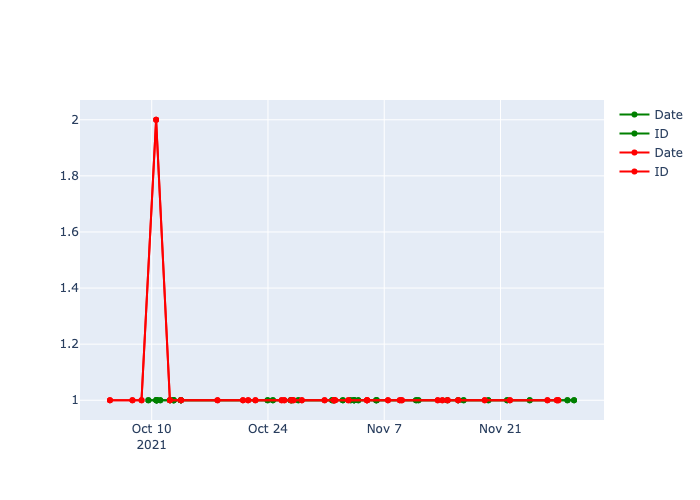

In [156]:
fig.show('png')

The spikes in negative sentiment shown above are almost the same as the original dataset. This signifies that any Wordclouds would be the same. It is interesting to note that there were much more negative sentiments in the larger dataset that assessed more terms. It should not be assumed that this is indicative of a large prevalence of mental health disorders within select Caribbean countries as Twitter users sometimes use these terms very flippantly. However, given that there are siginificantly more spikes of negative sentiments than positive, this should be taken into consideration and investigated further by health authorities. 

To conclude this analysis on mental health in the Caribbean, this part of the project confirmed that depression and anxiety are the more prevalent disorders but there is a recognition, among some Twitter users, of the importance of mental wellness. The 25 Year Mental Health dashboard showed that disorder levels have been more or less constant over the years but it appears that this may not be accurate given the prevalence of negative emotions. The WordCloud showed that there was a conference held on mental health and there were tweets with high likes and retweets that championed mental health care which means that more persons may be encouraged to seek care for their struggles. Again, health practitioners can use this as an indication of the openness of a considerable amount of the population to seek care and so they could devise treatment options around this. 